В цьому наборі завдань закріпимо те, що було на лекції з Computer Vision.

# Computer Vision with PyTorch Excercises. Solution


## 1. Наведіть 3 галузі промисловості, де комп'ютерний зір використовується сьогодні (можна згадати з лекції, або провести міні-рісерч).

1. Медицина: аналіз знімків типу рентген, МРТ, КТ і т.д
2. Рітейл: автоматичне розпізнавання покупця, товарів без кас.
3. Автомобільна промисловість: розпізнавання перешкод, розмітки, інших машин, пішоходів у реальному часі.

## 2. Виділіть 20 хвилин аби ознайомитись та переглянути сайт [CNN Explainer](https://poloclub.github.io/cnn-explainer/).

* Завантажте власне будь-яке зображення за допомогою кнопки Upload" на сайті та подивіться, що відбувається на кожному шарі CNN, коли ваше зображення проходить через нього.

Напишіть 3 пункти, що ви дізнались після цієї вправи?

До [CNN Explainer](https://poloclub.github.io/cnn-explainer/) було завантажене зображення морквини.

![carrot](./assets/carrot.png)

Отримано:
![carrot_cnn](./assets/cnn_explainer.png)


- Можемо побачити, як проходить обробка вихідного зображення через кожен шар моделі.
- Бачимо, що зліва вхідне зображення розбивається на 3 канали: Red, Green, Blue.
- Кожен шар створює кілька фільтрів — у цьому випадку 10, що показують активації фільтрів, де кожна активація — це результат проходження згортки по вхідному зображенню.
- Кожен згортковий клас навчається виявляти різні ознаки.
- Розмірність поступово зменшується, зберігаючи основну інформацію.



In [2]:
import time
import torch
from tqdm.auto import tqdm
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

In [2]:
use_gpu = True
DEVICE = "cuda" if use_gpu else "cpu"
DEVICE

'cuda'

## 3. Завантажте навчальні та тестові набори даних [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST).

MNIST - базовий набір даних для задач Computer Vision. Часто використовується для навчання.

- Виведіть, скільки елементів в кожному наборі.
- Покажіть формат (розмірності) кожної картинки.
- Виведіть, які класи представлені в цьому наборі даних.

In [3]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [4]:
print(f"Кількість зображень у train: {len(train_dataset)}; y test: {len(test_dataset)}")

Кількість зображень у train: 60000; y test: 10000


In [5]:
sample_img, sample_label = train_dataset[0]
print(f"Форма зображення: {sample_img.shape}")

Форма зображення: torch.Size([1, 28, 28])


## 4. Візуалізуйте щонайменше 5 різних зразків з навчального набору даних MNIST.

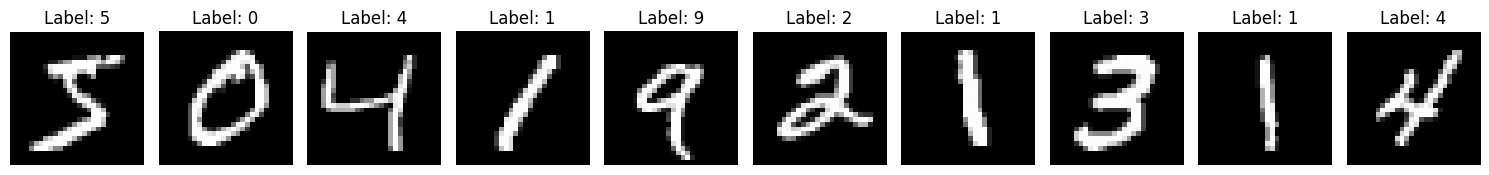

In [6]:
img_counts = 10
fig, axes = plt.subplots(1, img_counts, figsize=(15, 3))
for i in range(img_counts):
    image, label = train_dataset[i]
    axes[i].imshow(image.squeeze(), cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

## 5. Перетворіть навчальні та тестові набори даних MNIST у data loaders за допомогою `torch.utils.data.DataLoader`, встановіть `batch_size=32`.
- Покажіть, яку форму даних вертають дата лоадери.

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [8]:
images, labels = next(iter(train_loader))

In [9]:
print(images.shape)
print(labels.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32])


## 6. Відтворіть `ModelV2`, яку ми розглядали на лекції
Це до слова та сама модель з [сайту CNN Explainer](https://poloclub.github.io/cnn-explainer/), також відома як TinyVGG і вона здатна навчатися на наборі даних MNIST.

Напишіть клас моделі.

In [10]:
class MNISTModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x


## 7. Навчіть модель, яку ви побудували в попередній вправі, протягом 5 епох на CPU та GPU і подивіться, скільки часу це займе в кожному з варіантів.

In [11]:
def train_one_epoch(model, loader, loss_fn, optimizer, device, epoch_num=None):
    model.train()
    running_loss = 0.0
    loop = tqdm(loader, desc=f"Epoch {epoch_num}" if epoch_num else "Training", leave=False)
    for batch_idx, (images, labels) in enumerate(loop):
        images, labels = images.to(device), labels.to(device)

        preds = model(images)
        loss = loss_fn(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(loader)
    return avg_loss

In [12]:
model_cpu = MNISTModel(1, 10, 10)
loss_fn_cpu = nn.CrossEntropyLoss()
optimizer_cpu = optim.Adam(model_cpu.parameters(), lr=1e-3)

In [13]:
def train_model(model, loss_fn, device, optimizer):
    print(f"\nНавчання на {device.upper()}")
    model.to(device)
    start = time.perf_counter()
    for epoch in range(1, 6):
        avg_loss = train_one_epoch(model, train_loader, loss_fn, optimizer, device, epoch_num=epoch)
        print(f"Epoch {epoch}: avg_loss = {avg_loss:.4f}")
    total_time = time.perf_counter() - start
    print(f"Finished on {device:<4} in {total_time:.1f} s")


In [14]:
train_model(model=model_cpu, loss_fn=loss_fn_cpu, device="cpu", optimizer=optimizer_cpu)


Навчання на CPU


Epoch 1: avg_loss = 0.2515


Epoch 2: avg_loss = 0.0753


Epoch 3: avg_loss = 0.0593


Epoch 4: avg_loss = 0.0510


Epoch 5: avg_loss = 0.0440
Finished on cpu  in 228.5 s


In [15]:
model = MNISTModel(1, 10, 10)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [16]:
train_model(model=model, loss_fn=loss_fn, device=DEVICE, optimizer=optimizer)


Навчання на CUDA


Epoch 1: avg_loss = 0.2393


Epoch 2: avg_loss = 0.0811


Epoch 3: avg_loss = 0.0607


Epoch 4: avg_loss = 0.0501


Epoch 5: avg_loss = 0.0437
Finished on cuda in 103.0 s


Спостереження:

Бачимо, що час навчання моделі на CPU значно більший ніж на GPU, тож раціональніше використати в такому випадку для навчання моделі GPU.


## 8. Зробіть прогнози за допомогою вашої навченої моделі та візуалізуйте принаймні 5 з них, порівнюючи прогноз з цільовою міткою.

In [17]:
def make_predictions(model, data_loader, device, num_samples=5):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(12, 4))

    with torch.inference_mode():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for i in range(images.size(0)):
                if images_shown >= num_samples:
                    break

                plt.subplot(1, num_samples, images_shown + 1)
                plt.imshow(images[i].squeeze().cpu(), cmap='gray')
                plt.title(f"True: {labels[i].item()}\nPred: {preds[i].item()}")
                plt.axis("off")

                images_shown += 1

            if images_shown >= num_samples:
                break

    plt.tight_layout()
    plt.show()


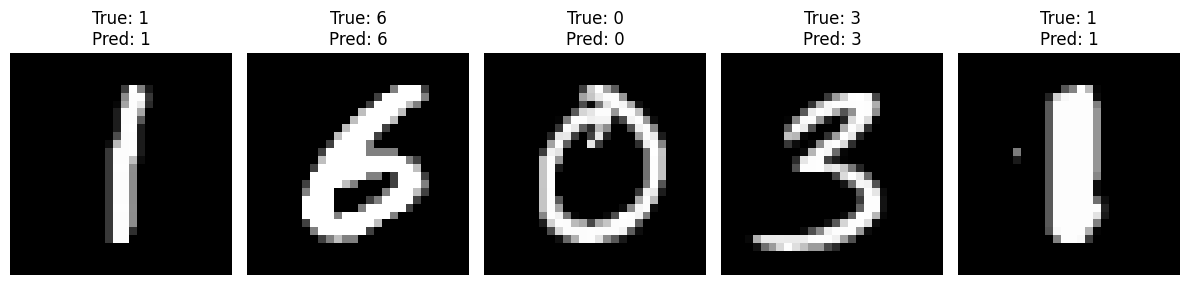

In [18]:
make_predictions(model, test_loader, DEVICE)

Спостереження:

З 5 прикладів що виведено - всі класифіковано правильно, але варто продивитись як себе демонструє модель на інших прикладах.

## 9. Побудуйте матрицю плутанини, порівнюючи передбачення вашої моделі з істинними мітками.

In [19]:
def plot_confusion_matrix(model, data_loader, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.inference_mode():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=class_names if class_names else list(range(10)))
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(ax=ax, cmap='Blues', colorbar=False, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()

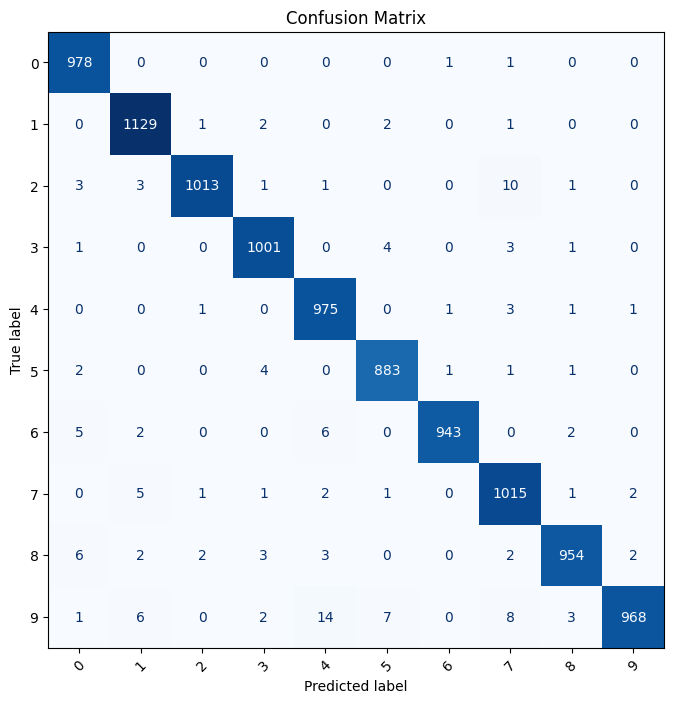

In [20]:
plot_confusion_matrix(model, test_loader, DEVICE)

Спостереження:

- Можемо бачити, що більшість передбачень моделі були правильними.
- Бачимо, що іноді цифри плутаються між собою.
- В цілому модель працює стабільно та достатньо точно.


## 10. Виведіть принаймні 9 прикладів, де модель помиляється, разом з тим, якою мала бути мітка зображення.
* Після візуалізації цих прогнозів, як ви думаєте, це більше помилка моделювання чи помилка даних?
* Тобто, чи може модель працювати краще, чи мітки даних занадто близькі одна до одної, що навіть людина не може чітко розрізнити що це за цифра?

In [21]:
def get_model_mistakes(model, data_loader, device, max_mistakes=9):
    model.eval()
    mistakes = []

    with torch.inference_mode():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            preds = model(images).argmax(dim=1)

            for img, pred, label in zip(images, preds, labels):
                if pred != label:
                    mistakes.append((img.cpu(), pred.item(), label.item()))
                    if len(mistakes) >= max_mistakes:
                        return mistakes
    return mistakes


In [22]:
def plot_mistakes(mistakes, title="Помилки моделей"):
    num_examples = len(mistakes)
    cols = 3
    rows = (num_examples + cols - 1) // cols

    plt.figure(figsize=(4 * cols, 4 * rows))
    for idx, (img, pred, true) in enumerate(mistakes):
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f"Pred: {pred} | True: {true}", color='red' if pred != true else 'green')
        plt.axis("off")
    plt.tight_layout()
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.show()


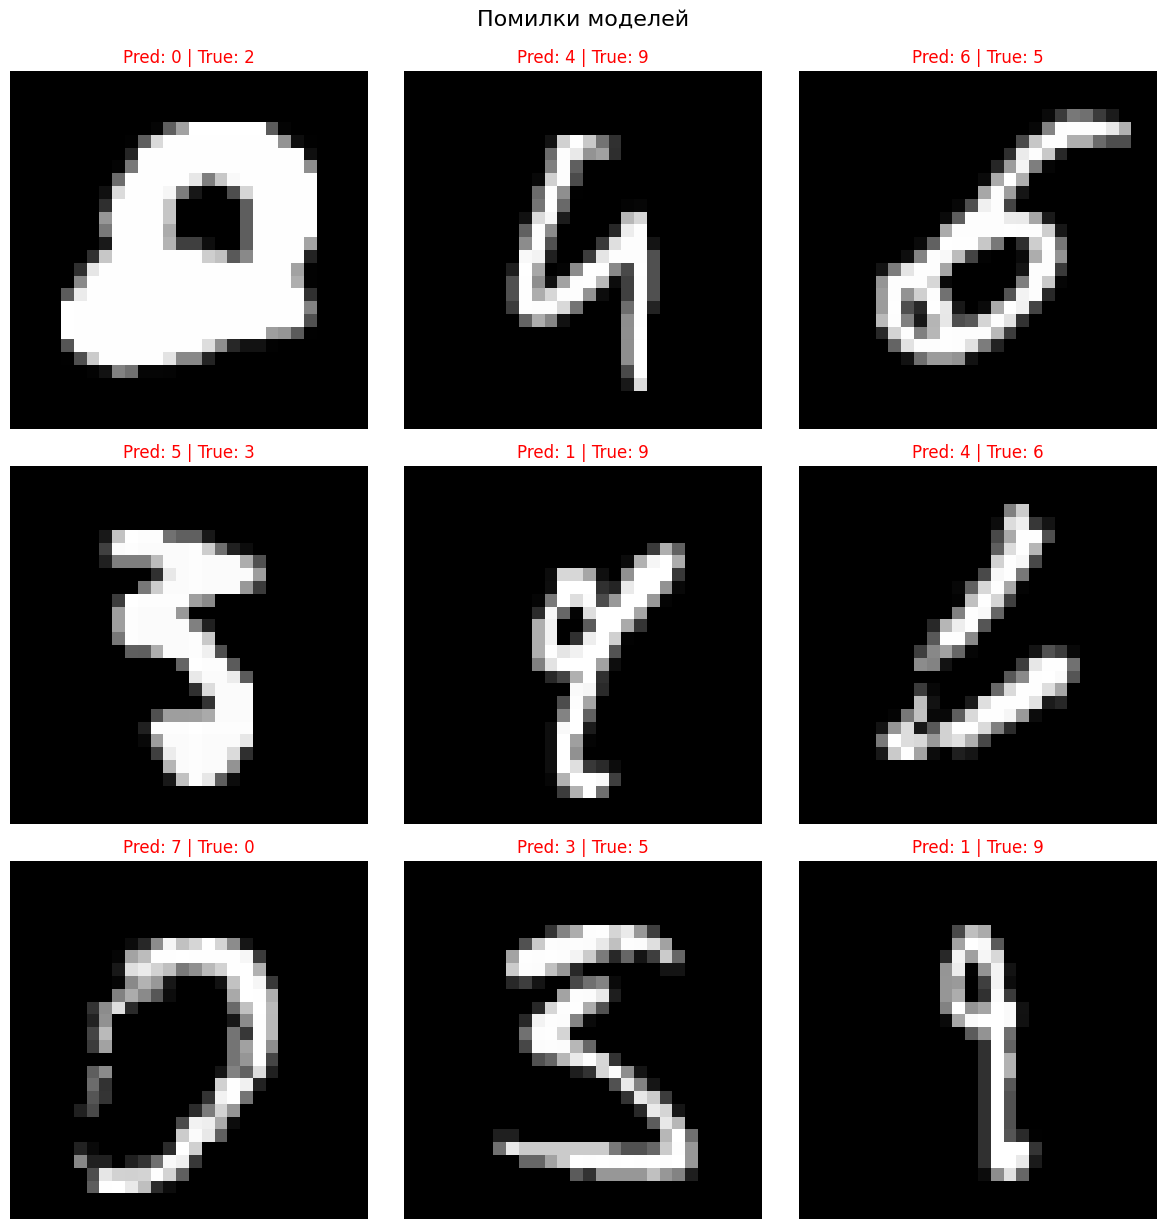

In [23]:
mistakes = get_model_mistakes(model, test_loader, DEVICE, max_mistakes=9)

plot_mistakes(mistakes)

Спостереження:

- В цілому можемо бачити, що модель припускається не грубих помилок, та у більшості випадків цифри написані не типово. Стиль написання може варіюватися і модель могла не побачити достатньо екземплярів з певним стилем написання.
- Такі помилки скоріше пов'язані з даними, ніж з проблемою моделювання, тож більше про наявність не типових прикладів у вибірці.
- Для людського ока деякі з зображень, на яких помиляється модель, також є не дуже очевидними, тож саме про такі екземпляри можна сказати, як про проблемні.

## 11. Створіть випадковий тензор форми `[1, 3, 64, 64]` і пропустіть його через шар `nn.Conv2d()` з різними налаштуваннями гіперпараметрів (ви можете вибрати будь-які налаштування), що ви помічаєте, якщо параметр `kernel_size` збільшується або зменшується?

In [24]:
x = torch.randn(1, 3, 64, 64)

In [25]:
kernel_sizes = [1, 3, 5, 7, 11]

for k in kernel_sizes:
    conv = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=k, stride=1, padding=0)
    out = conv(x)
    print(f"Kernel size: {k} → Output shape: {out.shape}")


Kernel size: 1 → Output shape: torch.Size([1, 8, 64, 64])
Kernel size: 3 → Output shape: torch.Size([1, 8, 62, 62])
Kernel size: 5 → Output shape: torch.Size([1, 8, 60, 60])
Kernel size: 7 → Output shape: torch.Size([1, 8, 58, 58])
Kernel size: 11 → Output shape: torch.Size([1, 8, 54, 54])


Спостереження:

Бачимо, що зі збільшенням kernel_size, розмір вихідного зображення зменшується. Це пов’язано з тим, що згортка охоплює більшу область зображення, але при цьому втрачає пікселі по краях — особливо без padding.
Чим більше ядро — тим менше залишає "простору для руху", і тим компактнішим стає вихід.